# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 6139

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


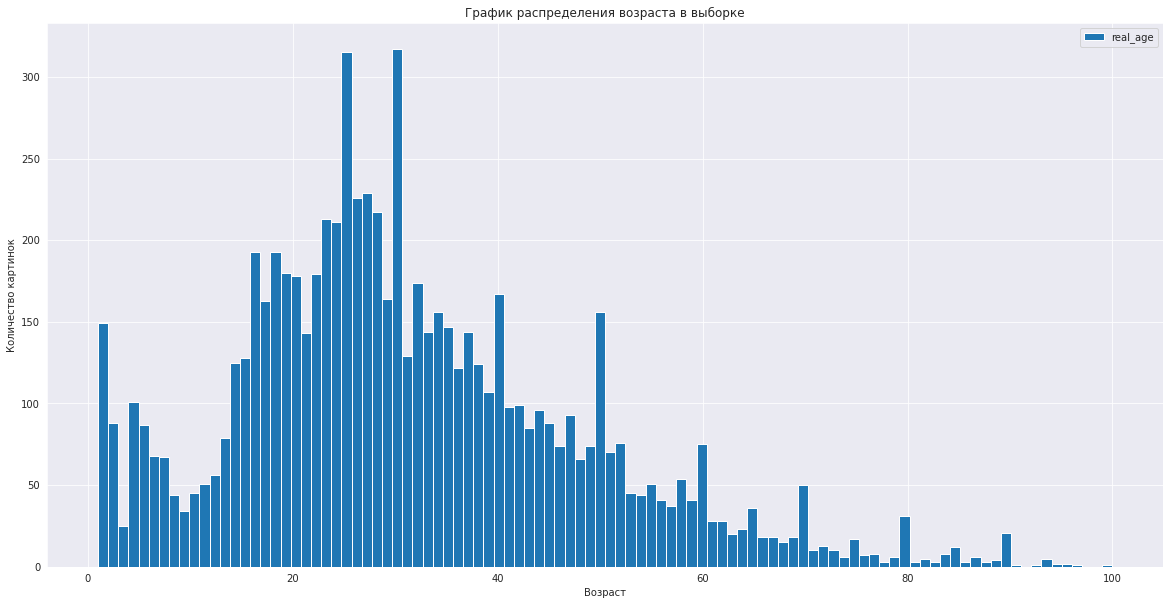

In [4]:
sns.set_style('dark')
df.plot(kind = 'hist', bins=100, figsize=(20,10), grid=True)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество картинок')
plt.show()

Сделаем срез по возрасту.  
Уберем младше 10 лет и старше 80, так как эти группы людей не является целевой аудиторией по проекту.

In [5]:
df = df.loc[(df['real_age']>10)
       & (df['real_age']<80)]

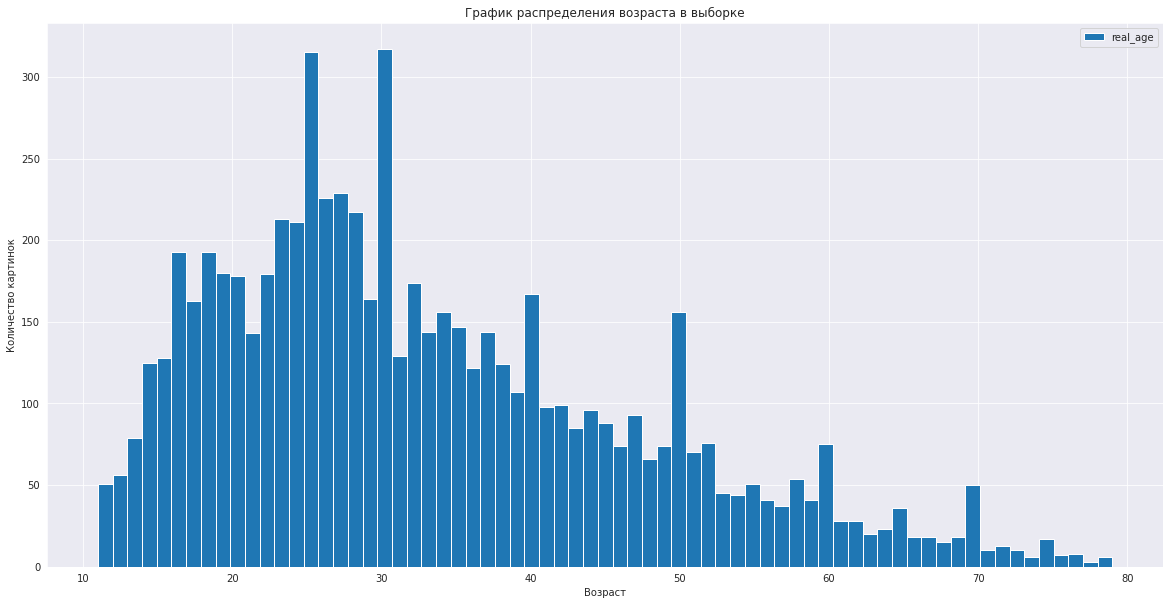

In [6]:
sns.set_style('dark')
df.plot(kind = 'hist', bins=69, figsize=(20,10), grid=True)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество картинок')
plt.show()

In [7]:
datagen = ImageDataGenerator(rescale=1/255)

datagen_flow = datagen.flow_from_dataframe(directory = '/datasets/faces/final_files/',
                                                 dataframe = df,
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 image_size=(150, 150),
                                                 batch_size=16,
                                                 class_mode = 'raw',
                                                 seed=RANDOM_STATE)

Found 6771 validated image filenames.


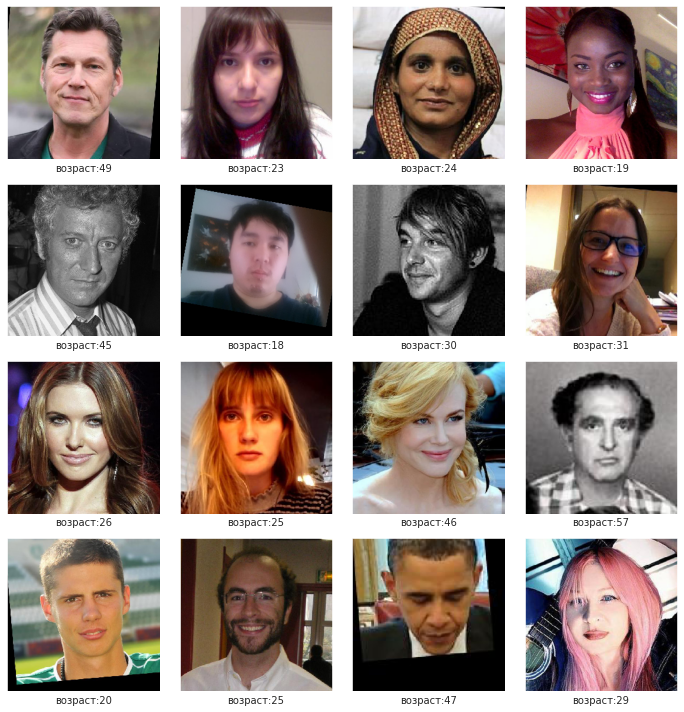

In [18]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel('возраст:'+ str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод по исседовательскому анализу данных:**

После результата среза данных в распоряжении для обучения модели 6771 фотографию, этого достаточно для того, чтобы использовать в качестве обучающей модели архитектуру ResNet без заморозки части слоев сети и при этом избежать переобучения.  

Так как большая часть фотографий представлена в промежутке от 15 до 50 лет можно сделать предположение, что модель гораздо хуже будет определять точность возраста людей старше 50 лет.  

Есть фотки обрезанные, со смещением, черно-белые, с цветовыми фильтрами, размытые, с  недостаточным количеством яркости и контрастности - все это надо учесть при создании и обучении модели.

## Обучение модели

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

In [10]:
def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1/255,
                                 validation_split=0.25,
                                 brightness_range=(0.8, 1.2),
                                 horizontal_flip=True)
    train_datagen_flow = datagen.flow_from_dataframe(directory = path + 'final_files/',
                                                 dataframe = df,
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 image_size=(224, 224),
                                                 batch_size=16,
                                                 class_mode = 'raw',
                                                 subset='training',
                                                 seed=6139)
    return train_datagen_flow

In [11]:
def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1/255,
                                 validation_split=0.25,)
    test_datagen_flow = datagen.flow_from_dataframe(directory = path + 'final_files/',
                                                 dataframe = df,
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 image_size=(224, 224),
                                                 batch_size=16,
                                                 class_mode = 'raw',
                                                 subset='validation',
                                                 seed=6139)
    return test_datagen_flow

In [12]:
def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    model = Sequential()
    optimizer = Adam(lr=0.0001)

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model 

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-06-28 17:04:03.610498: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-28 17:04:03.943320: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 73s - loss: 196.0284 - mae: 10.2746 - val_loss: 751.7899 - val_mae: 22.5315
Epoch 2/10
356/356 - 68s - loss: 84.5708 - mae: 6.9842 - val_loss: 147.7823 - val_mae: 9.5065
Epoch 3/10
356/356 - 68s - loss: 58.5387 - mae: 5.7924 - val_loss: 80.5419 - val_mae: 6.8410
Epoch 4/10
356/356 - 67s - loss: 44.7334 - mae: 5.0973 - val_loss: 84.5367 - val_mae: 6.9764
Epoch 5/10
356/356 - 67s - loss: 34.2393 - mae: 4.5260 - val_loss: 76.8366 - val_mae: 6.5449
Epoch 6/10
356/356 - 68s - loss: 24.6032 - mae: 3.7976 - val_loss: 67.9649 - val_mae: 6.1552
Epoch 7/10
356/356 - 64s - loss: 20.1203 - mae: 3.4789 - val_loss: 67.4134 - val_mae: 6.1124
Epoch 8/10
356/356 - 68s - loss: 18.0540 - mae: 3.2543 - val_loss: 63.7193 - val_mae: 6.0544
Epoch 9/10
356/356 - 68s - loss: 15.1229 - mae: 2.9590 - val_loss: 62.5420 - val_mae: 5.8764
Epoch 10/10
356/356 - 69s - loss: 13.5360 - mae: 2.8230 - val_loss: 60.5373 - val_mae: 5.8465

119/119 - 11s - loss: 60.5373 - mae: 5.8465
Test MAE: 5.8465

## Анализ обученной модели

**ВЫВОД:**  
Была поставлена задача: построить модель, которая по изображению с камеры определит приблизительный возраст человека. При этом показателем качества модели является метрика MAE (среднее абсолютное отклонение), которая на тестовой выборке должна была быть не больше 8.  

В качестве обучающей модели использовал архитектуру ResNet без заморозки части слоев.  
В процессе обучения использовал аугментацию смещения и яркости похожую на ту, которая была использована на части фотографиях в предоставленном  Dataset.  
Вместо стохастического градиентного спуска  (SGD) использовал оптимизацию Adam c очень маленьким шагом обучения 0.0001 (чтобы не пропустить локальный минимум при обучении глубоких нейросетей).  
В качестве функции потерь использовалась mean_squared_error, что увеличило скорость обучения.  
При обучении модель ведет себя стабильно, а значит параметры были подобраны верно.

По результатам обучения модели на 10 эпохах получил метрику MAE равную 5.85, что существенно меньше заданного параметра метрики, а, следовательно, можем рекомендовать данную модель к использованию.